# CTR Prediction on Ad data provided by Avazu

## Importing neccesary libraries

In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dask # used for in-memory large compution on a single machine
import random

#for visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs

import sklearn
import matplotlib.dates as mdates

In [3]:
matplotlib.style.use('ggplot')

## Data Sampling

As the data in quite large(~6gb) and the best way to handle this amount of data is to use cloud technologies like AWS. However, I am trying to handle this using single machine and unavailability of resources. The best approach to handle amount of data is **"Random Sampling"**

In [4]:

n = 40428967 # total number of rows in the data

sample_size = 1000000
random.seed(101) ## for maintaining the seed state.
skip_values = sorted(random.sample(range(1,n), n-sample_size))

In [5]:
#To manipulate the date feature so it can further analyzed at the EDA stage
parse_date = lambda date: pd.datetime.strptime(date, '%y%m%d%H')

## Loading the Data

In [6]:
from requirements import *
# train_path = "/Users/akash-mac/Desktop/My Docs/Self-Projects/Datasets/CTR Data/train"
train_data = pd.read_csv(train_path, 
                         parse_dates= ['hour'], 
                         date_parser=parse_date, 
                         skiprows=skip_values)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
id                  1000000 non-null uint64
click               1000000 non-null int64
hour                1000000 non-null datetime64[ns]
C1                  1000000 non-null int64
banner_pos          1000000 non-null int64
site_id             1000000 non-null object
site_domain         1000000 non-null object
site_category       1000000 non-null object
app_id              1000000 non-null object
app_domain          1000000 non-null object
app_category        1000000 non-null object
device_id           1000000 non-null object
device_ip           1000000 non-null object
device_model        1000000 non-null object
device_type         1000000 non-null int64
device_conn_type    1000000 non-null int64
C14                 1000000 non-null int64
C15                 1000000 non-null int64
C16                 1000000 non-null int64
C17                 1000000 non-null int64
C18      

## Memory management and Optimization

As we can see in the above cell, the memory usage is 183.1+ MB. Altering the data types from **int64** to **int32** will reduce the memory usage using **NumPy** 

In [8]:
data_types = {
    'id': np.str,
    'click': np.bool_,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16
}

In [9]:
#Reloading the data with new data types
train_data = pd.read_csv(train_path, 
                         parse_dates= ['hour'], 
                         date_parser=parse_date, 
                         skiprows=skip_values, 
                         dtype = data_types)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
id                  1000000 non-null object
click               1000000 non-null bool
hour                1000000 non-null datetime64[ns]
C1                  1000000 non-null uint16
banner_pos          1000000 non-null uint16
site_id             1000000 non-null object
site_domain         1000000 non-null object
site_category       1000000 non-null object
app_id              1000000 non-null object
app_domain          1000000 non-null object
app_category        1000000 non-null object
device_id           1000000 non-null object
device_ip           1000000 non-null object
device_model        1000000 non-null object
device_type         1000000 non-null uint16
device_conn_type    1000000 non-null uint16
C14                 1000000 non-null uint16
C15                 1000000 non-null uint16
C16                 1000000 non-null uint16
C17                 1000000 non-null uint16
C1

Memory usage decreased by 40% (107.8+ MB)

## Exploratory Data Analysis

In [11]:
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10014026899633599058,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15699,320,50,1722,0,35,34548,79
1,10036789730923212176,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15703,320,50,1722,0,35,65535,79
2,10045883484838411177,True,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20632,320,50,2374,3,39,65535,23
3,10054765563239787314,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,65535,79
4,10060080737601186118,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,34548,79


In [12]:
train_data.describe()

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1004.967451,0.287497,1.015193,0.330226,18837.135458,318.886004,60.012164,2112.125311,1.432311,227.231035,49082.698085,83.395284
std,1.097453,0.507002,0.528572,0.852523,4969.191751,21.258630,47.147516,610.221744,1.326406,351.596158,15448.714515,70.307156
min,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,34464.000000,1.000000
25%,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,34548.000000,23.000000
50%,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,34657.000000,61.000000
75%,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,65535.000000,101.000000
max,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,65535.000000,255.000000


### CTR - Click vs. No Click distribution

(%) of Clicked vs. Not Clicked

False    83.0843
True     16.9157
Name: click, dtype: float64


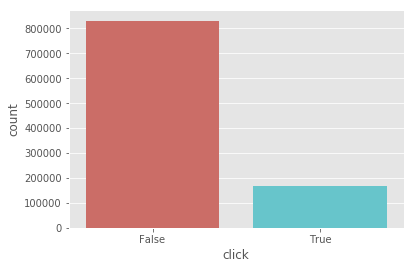

In [13]:
sns.countplot(x='click', data=train_data, palette='hls')
print("(%) of Clicked vs. Not Clicked\n")
print(train_data['click'].value_counts()*100/sample_size)

Click Through Rate for this sampled data is approx 17%, while the 83% did not clicked.

Let us check for the number of hours of total days of the data we have i.e. **10 day** i.e. **240 hours**

Text(0.5,1,'Number of clicks by hour')

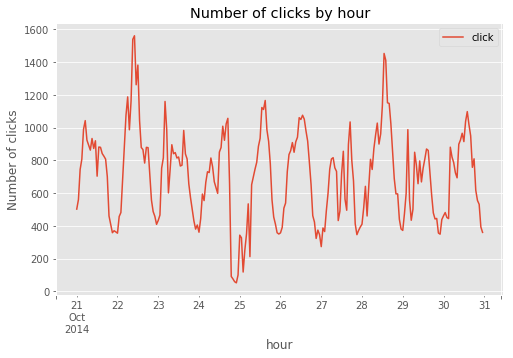

In [14]:
train_data.groupby('hour').agg({'click':'sum'}).plot(figsize = (8,5))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour')

The pattern looks pretty similar for all the 10 days. However, there are peaks between 22nd-23rd day and 28th-29th day. The lowest peak has be between 24th and 25th day.

### Breaking down date time feature and extracting hours

#### Hours

Text(0.5,1,'click trends by hour of day')

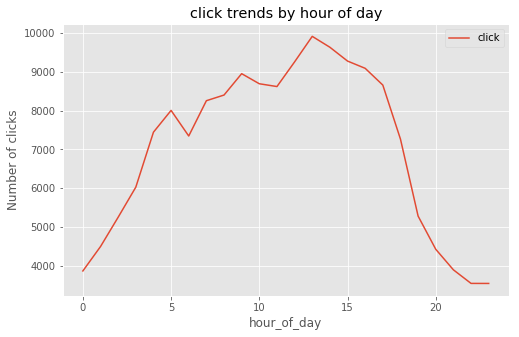

In [15]:
train_data['hour_of_day']=train_data.hour.apply(lambda x: x.hour)
train_data.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(8,5))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day')

Observing the above plot, it can be seen that the highest number of ads have been clicked in the afternoon time i.e. between the 13th and 14th hour (1pm-2pm). The least were at the 0th hour (mid night). Just to compare clicks vs. not clicks we can see the impressions in the below plot

Text(0.5,1,'Hourly impressions vs. clicks')

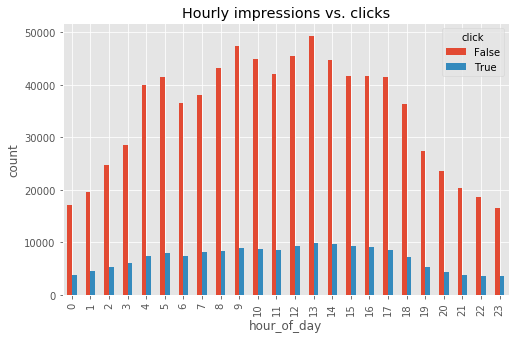

In [16]:
train_data.groupby(['hour_of_day', 'click']).size().unstack().plot(kind = 'bar', figsize = (8,5))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks')

### Calculating CTR using Impressions and Clicks

#### CTR - Hourly

In [17]:
df_click = train_data[train_data['click']==1]df_click = train_data[train_data['click']==1]

In [18]:
df_hour = train_data[['hour_of_day', 'click']].groupby(['hour_of_day']).count().reset_index()

In [19]:
df_hour = df_hour.rename(columns={'click':'impressions'})

In [20]:
df_hour['click'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']

In [21]:
df_hour['CTR'] = df_hour['click']*100/df_hour['impressions']

Plotting the Hourly CTR

In [22]:
df_hour.head()

,hour_of_day,impressions,click,CTR
0,0,20984,3867,18.428326
1,1,24192,4496,18.584656
2,2,29902,5252,17.564043
3,3,34612,6027,17.413036
4,4,47316,7444,15.732522


Text(0.5,1,'CTR - Hourly')

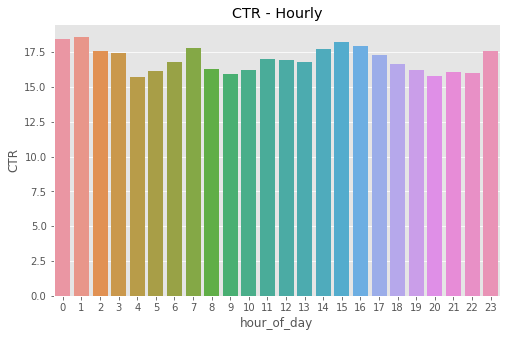

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(x='hour_of_day',y='CTR', data=df_hour)
plt.title('CTR - Hourly')

Here we can observe that the CTR for the mid night hours is higher compared to their clicks and impressions.

#### Day of Week

In [25]:
train_data['day_of_week'] = train_data['hour'].apply(lambda val: val.weekday_name)

Text(0.5,1,'Click Trends By Day of Week')

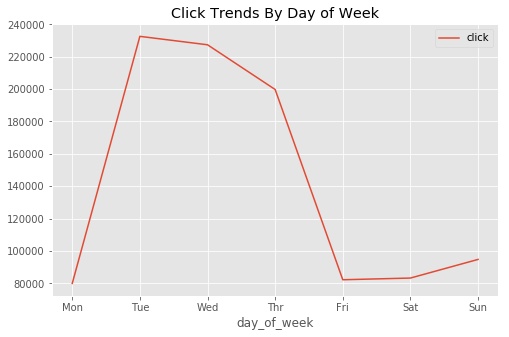

In [26]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_data[['day_of_week', 'click']].groupby(['day_of_week']).count().reindex(days).plot(figsize = (8,5))
plt.xticks(list(range(0,7,1)), "Mon Tue Wed Thr Fri Sat Sun".split())
plt.title('Click Trends By Day of Week')

In [27]:
train_data.groupby(['day_of_week', 'click']).size().unstack()

click,False,True
day_of_week,,
Friday,67924,14321
Monday,65510,14451
Saturday,68245,15049
Sunday,77468,17331
Thursday,164912,34839
Tuesday,195132,37445
Wednesday,191652,35721


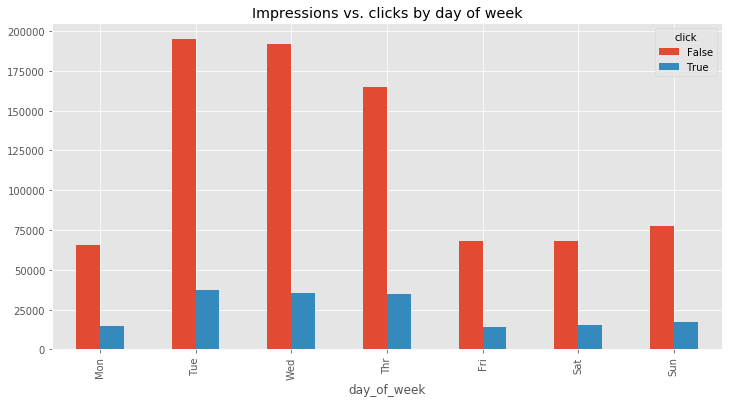

In [28]:
train_data.groupby(['day_of_week','click']).size().unstack().reindex(days).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(list(range(0,7,1)), "Mon Tue Wed Thr Fri Sat Sun".split())
plt.title('Impressions vs. clicks by day of week');

Tuesdays have the most number of impressions and clicks forllowed by Wednesdays followed by Thursdays. Mondays and Fridays have least nunber of impressions and clicks. 

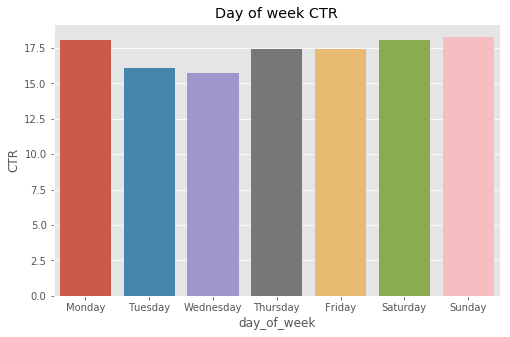

In [30]:
df_click = train_data[train_data['click'] == 1]
df_dayofweek = train_data[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100

plt.figure(figsize=(8,5))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

Comparing the Day of week CTR plot and impressions vs click plot, monday and weekends have less clicks but have a higher CTR. People are clicking more ads over weekends compared to weekdays.

#### C1 Anonymized Categorical Feature 

Let's check what information this feature provides and its distribution 

In [41]:
train_data['C1'].value_counts()/len(train_data)

1005    0.918280
1002    0.055257
1010    0.022399
1012    0.002857
1007    0.000846
1001    0.000221
1008    0.000140
Name: C1, dtype: float64

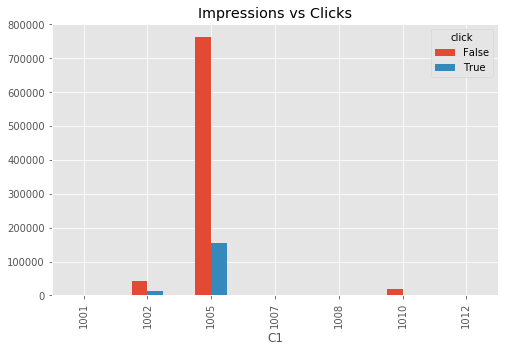

In [42]:
train_data.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(8,5), title='Impressions vs Clicks');

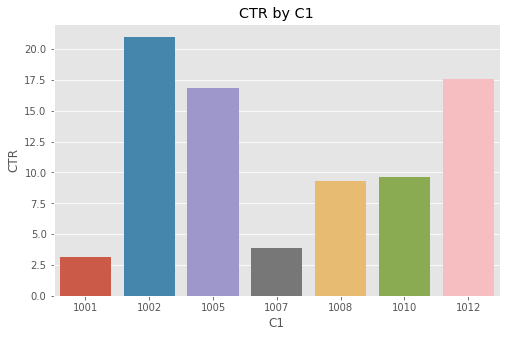

In [43]:
df_c1 = train_data[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100

plt.figure(figsize=(8,5))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1');

In [48]:
C1_values = train_data.C1.unique()
C1_values.sort()
ctr_avg_list=[]
print("CTR values for C1 categories:")
for i in C1_values:
    ctr_avg=train_data.loc[np.where((train_data.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("{} ==> CTR: {}".format(i,np.round(ctr_avg,3)))

CTR values for C1 categories:
1001 ==> CTR: 0.032
1002 ==> CTR: 0.21
1005 ==> CTR: 0.169
1007 ==> CTR: 0.039
1008 ==> CTR: 0.093
1010 ==> CTR: 0.096
1012 ==> CTR: 0.176


In [57]:
print("The average CTR for this data is {}".format(train_data['click'].mean()))

The average CTR for this data is 0.169157


According to information provided by the C1 values and their CTRs, these are the C1 values which are imporant in predicting CTR

* 1005: 92% of the data and 0.17 CTR
* 1002: 5.5% of the data and 0.21 CTR
* 1010: 2.3% of the data and 0.096 CTR

### Banner Position

According to digital marketing standards,banner positions holds an important factor and is considered as most influential.

In [63]:
train_data.banner_pos.value_counts()/sample_size

0    0.720711
1    0.277437
7    0.001091
2    0.000350
4    0.000210
5    0.000140
3    0.000061
Name: banner_pos, dtype: float64

In [64]:
banner_position = train_data.banner_pos.unique()
banner_position.sort()
ctr_avg_list=[]
print("CTR values for Banner Position values:")
for i in banner_position:
    ctr_avg=train_data.loc[np.where((train_data.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("{} ==> CTR: {}".format(i,np.round(ctr_avg,3)))

CTR values for Banner Position values:
0 ==> CTR: 0.164
1 ==> CTR: 0.183
2 ==> CTR: 0.094
3 ==> CTR: 0.131
4 ==> CTR: 0.19
5 ==> CTR: 0.093
7 ==> CTR: 0.306


The important banner positions are:

* position 0: 72% of the data and 0.16 CTR
* position 1: 28% of the data and 0.18 CTR